# 核心模块 Core Module

> 主要定义与任务相关的核心组件和配置
> 
> Defines core components and configurations related to tasks

## 简介/Description: 

核心模块包含任务相关的主要类和配置文件，如 ClassificationTask 和 ClassificationTaskConfig。其中配置文件通过 Pydantic 进行定义，帮助用户更好地构建图像分类任务的各个部分。

The core module contains the primary classes and configuration files related to tasks, such as ClassificationTask and ClassificationTaskConfig, where the configurations are defined using Pydantic, allowing users to easily structure components of image classification tasks.

## 主要符号/Main symbols:

- ClassificationTask: 用于处理图像分类任务的 PyTorch Lightning 模块。
- ClassificationTask: A PyTorch Lightning module for handling image classification tasks.
- ClassificationTaskConfig: 使用 Pydantic 设计的配置类，用于初始化任务。
- ClassificationTaskConfig: A configuration class designed with Pydantic for initializing the task.


In [64]:
#| default_exp core

In [65]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
#| export
import os
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com" # TODO this is optional for Foreigners

In [79]:
from transformers import AutoModel, AutoConfig, ViTModel, ViTConfig
from namable_classify.utils import print_model_pretty
AutoModel.from_pretrained("google/vit-base-patch16-224-in21k").training

/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


False

In [80]:
#| export
from pydantic import BaseModel
class ClassificationModelConfig(BaseModel):
    provider: str = "huggingface"
    checkpoint: str = "google/vit-base-patch16-224-in21k" # TODO 支持 hf  timm torch
    head_strategy: str = "linear"
    num_of_classes: int = -1
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoModel, AutoConfig, ViTModel, ViTConfig
from transformers import AutoImageProcessor, BitImageProcessor, ViTImageProcessor

class HuggingfaceModel(nn.Module):
    """Some Information about HuggingfaceModel"""
    def __init__(self, config : ClassificationModelConfig, forward_with_hf_image_preprocessor=False):
        super().__init__()
        # self.image_preprocessor = BitImageProcessor.from_pretrained(config.model_checkpoint, use_fast=True)
        self.image_preprocessor = AutoImageProcessor.from_pretrained(config.checkpoint)
        self.backbone: ViTModel = AutoModel.from_pretrained(config.checkpoint) # TODO we now just consider ViTModel
        self.backbone.train()
        self.backbone_config: ViTConfig = self.backbone.config # 包括了 image_size 和 hidden_size 这两个重要信息
        if config.head_strategy == "linear":
            self.head = nn.Linear(self.backbone_config.hidden_size, config.num_of_classes)
        else:
            raise NotImplementedError("Only linear head is supported for now. ")
        self.config = config
        self.forward_with_hf_image_preprocessor = forward_with_hf_image_preprocessor
    
    
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        if self.forward_with_hf_image_preprocessor:
            x = self.image_preprocessor(images=x, return_tensors="pt")["pixel_values"]
        hf_output = self.backbone(x)
        # hidden_state = hf_output.last_hidden_state
        output = hf_output.pooler_output
        output = self.head(output)
        return output
    
from fastcore.basics import patch
@patch
def get_cls_model(self:ClassificationModelConfig):
    if self.provider == "huggingface":
        return HuggingfaceModel(self)
    else:
        raise NotImplementedError("Only huggingface is supported for now. ")

In [81]:
#| export
import lightning as L
from pydantic import BaseModel
from namable_classify.data import ClassificationDataConfig, ClassificationDataModule

class ClassificationTaskConfig(BaseModel):
    experiment_index: int = 0  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 表示是第几次重复实验 # which is also the random seed
    label_smoothing: float = 0.1
    cls_model_config: ClassificationModelConfig = ClassificationModelConfig()
    dataset_config: ClassificationDataConfig = ClassificationDataConfig()
    learning_rate: float = 3e-4

In [82]:
#| export
import lightning as L
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT, OptimizerLRScheduler
from overrides import override
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from namable_classify.utils import print_model_pretty
from namable_classify.utils import partial_with_self, append_dict_list, compute_classification_metrics, ensure_array, logger
import numpy as np
from typing import Any
class ClassificationTask(L.LightningModule):
    def __init__(self, config: ClassificationTaskConfig)->None:
        super().__init__()
        self.save_hyperparameters(config.model_dump())
        L.seed_everything(config.experiment_index) # use index as the seed for reproducibility
        # 首先数据是可以加载的
        self.lit_data:ClassificationDataModule = config.dataset_config.get_lightning_data_module()
        # 数据怎么做Transform，取决于 Model的情况
        # 现在我们加载Model，刚才有了数据之后，首先可以更新 cls_model_config
        
        config.cls_model_config.num_of_classes = self.lit_data.num_of_classes
        self.cls_model:HuggingfaceModel = config.cls_model_config.get_cls_model()
        
        # 现在需要更新数据
        self.lit_data.set_transform_from_hf_image_preprocessor(hf_image_preprocessor=self.cls_model.image_preprocessor)
        
        model_image_size:tuple[int, int] = (self.cls_model.image_preprocessor.size['height'], self.cls_model.image_preprocessor.size['width'])
        self.example_input_array = torch.Tensor(1, self.cls_model.backbone.config.num_channels, *model_image_size)
        
        # 最后是训练策略
        self.softmax = nn.Softmax(dim=1)    
        self.loss = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        # nn.LogSoftmax(dim=1)
        # https://blog.csdn.net/qq_43391414/article/details/118421352 logsoftmax+nll的速度快，但是没有label smoothing
        
        # 评价策略
        self.evaluation_steps_outputs = dict()
    
    def compute_model_logits(self, image_tensor:torch.Tensor)-> torch.Tensor:
        return self.cls_model(image_tensor)
    
    @override
    def forward(self, image_tensor:torch.Tensor, *args, **kwargs)-> torch.Tensor:
        return self.softmax(self.compute_model_logits(image_tensor))

    def forward_loss(self, image_tensor: torch.Tensor, label_tensor:torch.Tensor)->torch.Tensor:
        probs = self(image_tensor)
        # return F.nll_loss(logits, label_tensor)
        return self.loss(probs, label_tensor)
    
    @override
    def training_step(self, batch, batch_idx=None, *args, **kwargs)-> STEP_OUTPUT:
        loss = self.forward_loss(*batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    @override    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # return L.AdamW(self.parameters(), lr=self.learning_rate)

    # 现在我们已经定义好Training的逻辑了，已经可以跑训练了。然而，除了训练之外，我们需要评测模型的性能。
    # @override
    # def 
    def on_evaluation_epoch_start(self, stage:str=""):
        self.evaluation_steps_outputs = dict()
        self.evaluation_steps_outputs[f'{stage}_batch_probs'] = []
        self.evaluation_steps_outputs[f'{stage}_label_tensor'] = []
            
    def evaluation_step(self, batch, batch_idx=None, stage:str="", *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image_tensor, label_tensor = batch
        batch_probs = self(image_tensor)
        append_dict_list(self.evaluation_steps_outputs, f'{stage}_batch_probs', ensure_array(batch_probs))
        append_dict_list(self.evaluation_steps_outputs, f'{stage}_label_tensor', ensure_array(label_tensor))
        batch_loss = self.loss(batch_probs, label_tensor)
        self.log(f"{stage}_loss", batch_loss, prog_bar=True)
        return batch_loss
            
    def on_evaluation_epoch_end(self, stage:str=""):
        # https://github.com/Lightning-AI/pytorch-lightning/discussions/9845
        # labels = self.lit_data.classes
        labels = list(range(self.lit_data.num_of_classes))
        # labels = None
        # print(labels)
        # stack 是 new axis， concat是existing axis
        all_pred_probs = np.concatenate(self.evaluation_steps_outputs[f'{stage}_batch_probs'])
        all_label_tensor = np.concatenate(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
        # logger.debug(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
        # logger.debug(all_label_tensor)
        eval_dict = compute_classification_metrics(all_label_tensor, all_pred_probs, logits_to_prob=False, 
                                                labels=labels)
        eval_dict = {f"{stage}_{k}": v for k,v in eval_dict.items()}
        self.log_dict(eval_dict)
        self.evaluation_steps_outputs.clear()

    def on_validation_epoch_start(self):
        return self.on_evaluation_epoch_start(stage="val")

    def on_test_epoch_start(self):
        return self.on_evaluation_epoch_start(stage="test")

    def on_validation_epoch_end(self):
        return self.on_evaluation_epoch_end(stage="val")

    def on_test_epoch_end(self):
        return self.on_evaluation_epoch_end(stage="test")

    def validation_step(self, batch, batch_idx=None):
        return self.evaluation_step(batch, batch_idx, stage="val")

    def test_step(self, batch, batch_idx=None):
        return self.evaluation_step(batch, batch_idx, stage="test")


In [83]:
config = ClassificationTaskConfig()
config
cls_task = ClassificationTask(config)
cls_task.print_model_pretty()

Seed set to 0


/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


root
└── cls_model (HuggingfaceModel)
    ├── backbone (ViTModel)
    │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]
    │   │   └── patch_embeddings (ViTPatchEmbeddings)
    │   │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]
    │   ├── encoder (ViTEncoder)
    │   │   └── layer (ModuleList)
    │   │       └── 0-11(ViTLayer)
    │   │           ├── attention (ViTAttention)
    │   │           │   ├── attention (ViTSelfAttention)
    │   │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]
    │   │           │   └── output (ViTSelfOutput)
    │   │           │       └── dense (Linear) weight:[768, 768] bias:[768]
    │   │           ├── intermediate (ViTIntermediate)
    │   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
    │   │           ├── output (ViTOutput)
    │   │           │   └── dense (Linear) weight:[768, 3072] bias:[768]
    │   │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]
    │   ├── layernorm (LayerNorm) weight:[768] bias:[768]
    │   └── pooler (ViTPooler)
    │       └── dense (Linear) weight:[768, 768] bias:[768]
    └── head (Linear) weight:[100, 768] bias:[100]

In [84]:
trainer = L.Trainer()
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
found_batch_size = tuner.scale_batch_size(cls_task, datamodule=cls_task.lit_data, 
                                          mode='binsearch', 
                                          init_val=64)
found_batch_size, cls_task.lit_data.hparams.batch_size

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


Files already downloaded and verified
Files already downloaded and verified


Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
2024-10-16 02:28:17.226 | WARNING  | namable_classify.utils:wrapper:77 - An exception occurred: Only one class present in y_true. ROC AUC score is not defined in that case.
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-package

(64, 88)

Files already downloaded and verified
Files already downloaded and verified


Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
2024-10-16 01:57:11.178 | DEBUG    | __main__:on_evaluation_epoch_end:88 - [array([53, 61, 98, 87, 64, 24, 75, 96, 83, 91, 87, 51, 39, 33, 94, 65, 16,
       30, 53, 14, 36, 61, 22, 88, 51, 97, 10,  5, 63, 74, 17, 37, 21,  5,
       68, 99, 14,  4, 3

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0009549925860214355
Restoring states from the checkpoint path at /home/ycm/repos/research/cv/cls/NamableClassify/nbs/.lr_find_ab7b2b77-ac06-4c1e-bb85-5d354d820071.ckpt
Restored all states from the checkpoint at /home/ycm/repos/research/cv/cls/NamableClassify/nbs/.lr_find_ab7b2b77-ac06-4c1e-bb85-5d354d820071.ckpt


{'lr': [1e-08, 1.3182567385564071e-08, 1.5135612484362082e-08, 1.7378008287493757e-08, 1.9952623149688796e-08, 2.2908676527677733e-08, 2.630267991895382e-08, 3.019951720402016e-08, 3.4673685045253164e-08, 3.981071705534973e-08, 4.570881896148751e-08, 5.248074602497726e-08, 6.025595860743578e-08, 6.918309709189366e-08, 7.943282347242814e-08, 9.120108393559099e-08, 1.0471285480508999e-07, 1.2022644346174127e-07, 1.380384264602885e-07, 1.5848931924611136e-07, 1.8197008586099835e-07, 2.0892961308540398e-07, 2.398832919019491e-07, 2.7542287033381663e-07, 3.162277660168379e-07, 3.630780547701014e-07, 4.1686938347033557e-07, 4.786300923226385e-07, 5.495408738576244e-07, 6.309573444801932e-07, 7.244359600749902e-07, 8.317637711026711e-07, 9.549925860214362e-07, 1.0964781961431853e-06, 1.2589254117941667e-06, 1.4454397707459273e-06, 1.6595869074375605e-06, 1.9054607179632473e-06, 2.187761623949553e-06, 2.511886431509581e-06, 2.884031503126605e-06, 3.3113112148259103e-06, 3.801893963205612e-06, 

(0.0009549925860214355, 0.0009549925860214355)

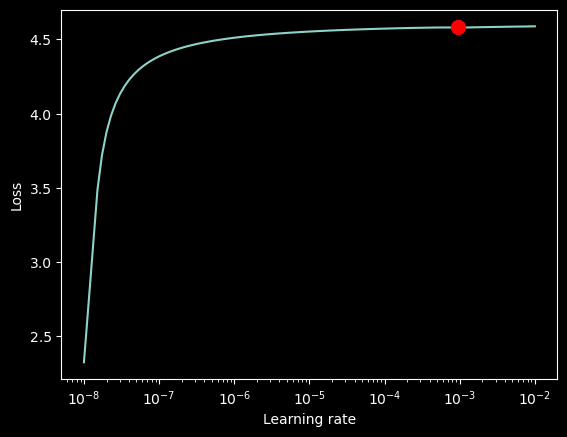

In [43]:
lr_finder = tuner.lr_find(cls_task, datamodule=cls_task.lit_data, max_lr=1e-2)
print(lr_finder.results)
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
new_lr, cls_task.hparams.learning_rate

In [ ]:
# @patch
# def get_early_stop_callback(self: ClassificationTask, monitor='valid_loss', min_delta=0, patience=1, mode='min'):

In [85]:
# size = cls_task.cls_model.image_preprocessor.size['height']
# cls_task.example_input_array = torch.Tensor(1, cls_task.cls_model.backbone.config.num_channels, size, size)
cls_task.example_input_array.shape

torch.Size([1, 3, 224, 224])

In [86]:
from namable_classify.utils import runs_path
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelSummary
trainer = L.Trainer(default_root_dir=runs_path, enable_checkpointing=True, 
                    enable_model_summary=True, 
                    num_sanity_val_steps=2, # 防止 val 在训了好久train才发现崩溃
                    callbacks=[
                        # EarlyStopping(monitor="val_loss", mode="min")
                        EarlyStopping(monitor="val_acc1", mode="max", check_finite=True, 
                                      patience=5, 
                                      check_on_train_epoch_end=False,  # check on validation end
                                      verbose=True),
                        ModelSummary(max_depth=3),
                               ]
                    , fast_dev_run=True
                    # limit_train_batches=10, limit_val_batches=5
                    )
trainer.fit(cls_task, datamodule=cls_task.lit_data)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Files already downloaded and verified
Files already downloaded and verified


Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                          | Type             | Params | Mode  | In sizes                                                                                     | Out sizes    
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | cls_model                     | HuggingfaceModel | 86.5 M | train | [1, 3, 224, 224]                                                                             | [1, 100]     
1 | cls_model.backbone            | ViTModel         | 86.4 M | train | [1, 3, 224, 224]                                                                             | ?            
2 | cls_model.backbone.embeddings | ViTEmbeddings    | 742 K  | train | [[1, 3, 224, 224], '?', '?']                                                                 | [1, 197, 768]
3 | cls_model.back

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-16 02:29:31.700 | WARNING  | namable_classify.utils:wrapper:77 - An exception occurred: Only one class present in y_true. ROC AUC score is not defined in that case.
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/sklearn/metrics/_classificati

In [77]:
cls_task.cls_model.backbone.print_model_pretty()
cls_task.cls_model.backbone.training

root
├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]
│   └── patch_embeddings (ViTPatchEmbeddings)
│       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]
├── encoder (ViTEncoder)
│   └── layer (ModuleList)
│       └── 0-11(ViTLayer)
│           ├── attention (ViTAttention)
│           │   ├── attention (ViTSelfAttention)
│           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]
│           │   └── output (ViTSelfOutput)
│           │       └── dense (Linear) weight:[768, 768] bias:[768]
│           ├── intermediate (ViTIntermediate)
│           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
│           ├── output (ViTOutput)
│           │   └── dense (Linear) weight:[768, 3072] bias:[768]
│           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]
├── layernorm (LayerNorm) weight:[768] bias:[768]
└── pooler (ViTPooler)
    └── dense (Linear) weight:[768, 768] bias:[768]

False

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()